<a href="https://colab.research.google.com/github/zaidtas/EML-Assignment/blob/master/Flatcam_recons_naive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import numpy as np
#from PIL import Image
import skimage as sk
from scipy import ndimage, misc
import scipy.io as sio
from matplotlib import pyplot as plt

print('All modules imported.')

All modules imported.


In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = 'REPLACE_WITH_YOUR_FILE_ID'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#joke.png
im=sk.io.imread("raw_bayer.jpg")

In [0]:
def image2double(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0, 1]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # TODO: Implement Min-Max scaling for grayscale image data
    a=0
    b=1
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

In [0]:
# Convert RAW images to Bayer
def raw_to_bayer(im,calib_angle,senSize): #im is an np array
  # print(np.shape(calib_angle))
  im = sk.img_as_float64(im)
  # k = im[1::2,1::2]
  # print(k.shape[0])
  Y=np.zeros((im.shape[0]//2,im.shape[1]//2,4))
  Y[:,:,0] = im[1::2,1::2]
  Y[:,:,1] = im[0::2,1::2]
  Y[:,:,2] = im[1::2,0::2]
  Y[:,:,3] = im[0::2,0::2]

  #rotate for alignment
  Y = ndimage.rotate(Y, calib_angle); #bilinear and crop
 
  #Crop sensor portion used in calibration
  start_row = (Y.shape[0] - senSize[0])//2 + 1;
  end_row = start_row + senSize[0] - 1;
  start_col = (Y.shape[1] - senSize[1])//2 + 1;
  end_col = start_col + senSize[1] - 1;
  Y = Y[start_row:end_row+1,start_col:end_col+1,:]
  return Y


In [0]:
def makeSeparable(im):
  rowMeans = np.mean(im,axis=1)
  colMeans = np.mean(im,axis=0)
  allMean = np.mean(colMeans)

  output=im-rowMeans[:,np.newaxis]-colMeans+allMean
  return output


In [124]:
# im=sk.io.imread("002.png")
# sk.io.imshow(im)

# print(np.shape(im))
mat_fname="flatcam_calibdata.mat"
calib = sio.loadmat(mat_fname,squeeze_me=True)

lmbd = 1e-3


print(im.shape)
Y=raw_to_bayer(im,calib['angle'],calib['cSize'])
Y = makeSeparable(Y)


(1024, 1280)


In [125]:
print(np.shape(Y))


(500, 620, 4)


In [0]:
sorted(calib.keys())
# calib['DL_all']
# k=calib['UL_all']
# np.shape(k)

In [0]:
def bayer2rgb(im_bayer):
  im_rgb=np.zeros((im_bayer.shape[0],im_bayer.shape[1],3))
  # print(np.shape(im_rgb))
  # print(np.shape(im_bayer))
  im_rgb[:,:,0]=im_bayer[:,:,0]
  im_rgb[:,:,1] = 0.5*(im_bayer[:,:,1]+im_bayer[:,:,2])
  im_rgb[:,:,2] = im_bayer[:,:,3]
  
  #normalize
  im_rgb = (im_rgb - im_rgb.min()) / (im_rgb.max() - im_rgb.min())
  return im_rgb

[[0.0029266  0.00270387 0.00282445 0.00250261 0.00218012 0.00249578
  0.00288346 0.0030963  0.00335887 0.00366141]
 [0.00309718 0.00285906 0.00301596 0.00267674 0.00239091 0.00279805
  0.00326259 0.00350342 0.0038206  0.00418683]
 [0.00296224 0.00265449 0.00281619 0.0024524  0.0021847  0.00263287
  0.00312169 0.00340995 0.00375938 0.0041421 ]
 [0.00282055 0.002518   0.00272758 0.00231389 0.00201784 0.00247504
  0.00297782 0.00325722 0.00362472 0.00406805]
 [0.00285958 0.00251854 0.00265967 0.00218238 0.00177674 0.00226084
  0.00281292 0.00308028 0.00351021 0.00414319]
 [0.00282734 0.00252521 0.00268849 0.00224953 0.00183061 0.00234482
  0.00293787 0.00320011 0.00366019 0.00434835]
 [0.00325256 0.00297336 0.00323478 0.00279854 0.00234886 0.00288892
  0.00356719 0.00380367 0.00432733 0.0050805 ]
 [0.00350362 0.00322996 0.00349051 0.00307657 0.00259653 0.00317941
  0.00389885 0.00410966 0.00462371 0.00534192]
 [0.00388165 0.00361709 0.00393194 0.00356772 0.00310514 0.00373457
  0.00455512

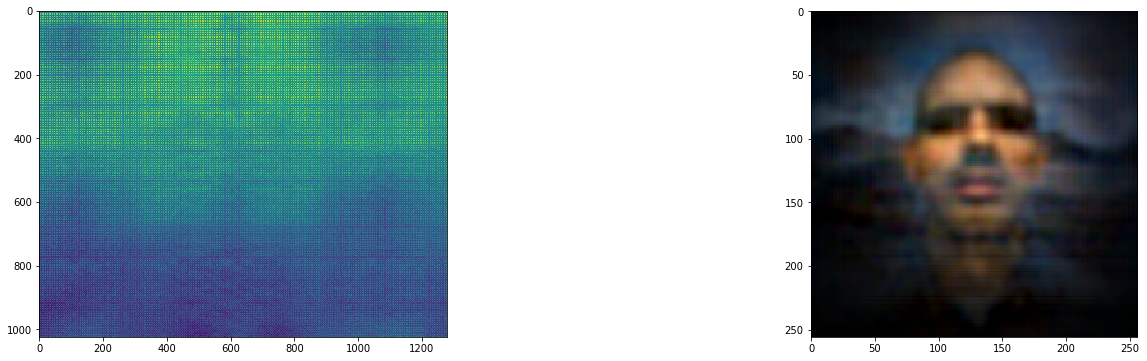

In [187]:
T = np.transpose
     
X_bayer=np.zeros((calib['VL_all'].shape[0],calib['VL_all'].shape[1],4))
# X_bayer=np.zeros(256,256,4)
for c in range(4):
    UL = calib['UL_all'][:,:,c]
    DL = calib['DL_all'][:,:,c]
    VL = calib['VL_all'][:,:,c]
    singL = calib['singL_all'][:,c]
    UR = calib['UR_all'][:,:,c]
    DR = calib['DR_all'][:,:,c]
    VR = calib['VR_all'][:,:,c]
    singR = calib['singR_all'][:,c]

    num=np.linalg.multi_dot([T(DL),T(UL),Y[:,:,c],UR,DR])
    # print(type(DL))
    # print(np.shape(DL))
    den=(singL**2).dot(T(singR**2))+lmbd*np.ones_like(singL)
    # print(den.shape)
    X_bayer[:,:,c]=VL.dot(num/den).dot(T(VR))
   
X_bayer[X_bayer<0] = 0 # non-negative constraint

recn = bayer2rgb(X_bayer)



gamma = 0.85
recn=recn**gamma

fig = plt.figure(figsize=(24,6))
plt.subplot(121)
plt.imshow(im)
plt.subplot(122)
plt.imshow(recn)



In [64]:
# print(im.shape)
# print(type(im))
a = np.random.randint(2, size=(4, 3))
print(a)
rowMeans = np.mean(a,axis=1)
colMeans = np.mean(a,axis=0)
allMean = np.mean(colMeans)

print(rowMeans)
print(colMeans)
print(allMean)

#   row_means_col_vec = row_means.reshape((4, 1))  # Better: np.newaxis.
# >>> broadcast_demeaned = arr - row_means_col_vec

output=a-rowMeans[:, np.newaxis] 
print(output)
output=output-colMeans
print(output)
output+=allMean
print(output)

# print(type(a))
# a[0::2,0::2]

[[1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 1]]
[0.33333333 0.33333333 0.33333333 0.66666667]
[0.5  0.5  0.25]
0.4166666666666667
[[ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [ 0.33333333 -0.66666667  0.33333333]]
[[ 0.16666667 -0.83333333 -0.58333333]
 [-0.83333333  0.16666667 -0.58333333]
 [-0.83333333  0.16666667 -0.58333333]
 [-0.16666667 -1.16666667  0.08333333]]
[[ 0.58333333 -0.41666667 -0.16666667]
 [-0.41666667  0.58333333 -0.16666667]
 [-0.41666667  0.58333333 -0.16666667]
 [ 0.25       -0.75        0.5       ]]


In [36]:
a = np.random.randint(2, size=(5, 5))
print(a)
j=[]
j=a[1::2,0::2]
print(j)

[[0 0 1 0 0]
 [1 1 1 1 1]
 [1 1 1 0 0]
 [0 0 1 1 0]
 [0 1 1 1 0]]
[[1 1 1]
 [0 1 0]]


TypeError: ignored